### kaggle 집값 예측 문제

columns

- `house_id` - 주택 id변수
- `date` - 판매된 날자
- `location` - 주택 위치
- `type` - 주택 유형 ("2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE")
- `block` - 주택이 위치한 블록
- `street` - 주택이 위치한 거리
- `storey_range` - 주택이 위치한 층 범위
- `flat_model` - 주택의 모델(구조, 방 배치 등)
- `commence_date` - 주택이 판매에 올라온 날짜
- `price` - 판매 가격 (목표 변수)

다양한 변수를 사용하여 짒값을 예측한다
-> baseline code작성

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor

In [2]:
# 데이터 불러오기
try:
    data = pd.read_csv('data/test.csv',encoding='utf-8')
    train = pd.read_csv('data/train.csv',encoding='utf-8')
except UnicodeDecodeError:
    # UTF-8로 실패할 경우 CP949로 재시도
    data = pd.read_csv('data/test.csv',encoding='cp949-8')
    train = pd.read_csv('data/train.csv',encoding='cp949')

In [12]:
data.tail()

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date
67925,339632,2012-02,Riverside,4 ROOM,610,Northpark Dr,04 TO 06,84.0,N,1986
67926,339639,2012-02,Riverside,5 ROOM,796,Laredo Rd,04 TO 06,123.0,D,1987
67927,339642,2012-02,Riverside,5 ROOM,855,Laredo Rd,04 TO 06,127.0,D,1988
67928,339643,2012-02,Riverside,5 ROOM,366,Laredo Rd,07 TO 09,122.0,D,1988
67929,339644,2012-02,Riverside,5 ROOM,115B,Laredo Rd,16 TO 18,111.0,D,2001


In [13]:
train.tail()

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price
271716,101563,2003-01,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0
271717,28297,2000-11,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0
271718,321995,2011-04,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0
271719,308162,2010-09,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0
271720,225691,2007-10,Milwaukee,EXECUTIVE,341,W Fond du Lac Avenue,04 TO 06,143.0,C,1993,450000.0


### EDA

In [14]:
#기초 통계량 확인
train.describe()

,house_id,area_sqm,commence_date,price
count,271721.000000,271721.000000,271721.000000,271721.000000
mean,169785.994870,96.544832,1987.982942,281197.589537
std,98022.533902,25.587877,9.125141,112160.993184
min,1.000000,28.000000,1966.000000,28000.000000
25%,85021.000000,73.000000,1981.000000,195000.000000
50%,169739.000000,99.000000,1987.000000,263000.000000
75%,254609.000000,115.000000,1997.000000,350000.000000
max,339651.000000,280.000000,2010.000000,903000.000000


In [16]:
#결측치 확인, 결측치 없음
train.isna().sum()

house_id         0
date             0
location         0
type             0
block            0
street           0
storey_range     0
area_sqm         0
flat_model       0
commence_date    0
price            0
dtype: int64

In [3]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['Year'] = tmp['date'].dt.year
train['Month'] = tmp['date'].dt.month


In [4]:
train.drop('date', axis=1, inplace=True)

In [21]:
#정규화
categorical_features = ['location', 'type', 'block', 'street', 'storey_range', 'flat_model']
numerical_features = ['area_sqm']

le = LabelEncoder()
for i in categorical_features:
    train[i] = le.fit_transform(train[i])

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

storey_range 는 층을 나타냄 -> 근대 5층을 4~6층이라고 나타내는데? -> 그냥 숫자 5로 바꾸는것 아님 그냥 범주형 변수로 원-핫 인코딩 하는거 뭐가 좋지?

날자 year month는 정규화를 하는 게 좋나?

추가할 피쳐 -> 팔리기 까지 걸린 기간 (연도차이로)

분류 말고 회귀에서는 TP, FP 등의 값이 어떻게 바뀌는 것인가

In [22]:
train

,house_id,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price,Year,Month
0,199577,19,4,34,26,2,0.325397,3,2003,313000.0,2006,9
1,217021,9,2,1445,102,2,0.142857,13,1988,167000.0,2007,6
2,308062,24,3,1092,146,3,0.253968,10,1976,430000.0,2010,9
3,212465,3,3,742,333,3,0.253968,10,1977,303800.0,2007,4
4,60654,10,3,1662,32,1,0.293651,6,1998,212000.0,2001,10
...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,16,3,1004,407,1,0.297619,6,1989,232000.0,2003,1
271717,28297,16,4,1257,50,3,0.420635,6,1996,428000.0,2000,11
271718,321995,5,4,853,215,4,0.357143,3,2004,548888.0,2011,4
271719,308162,9,3,1936,243,4,0.246032,8,1999,360000.0,2010,9


In [23]:
X = train.drop('price', axis = 1)
y = train['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 모델로드 및 학습

In [24]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

In [25]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 예측 및 모델 평가

In [28]:
# 예측
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [29]:
# 성능 평가
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 4878.46874987395, Train R^2: 0.9958279540761996
Test MAE: 13057.05825255313, Test R^2: 0.9708954705653287


### 시각화

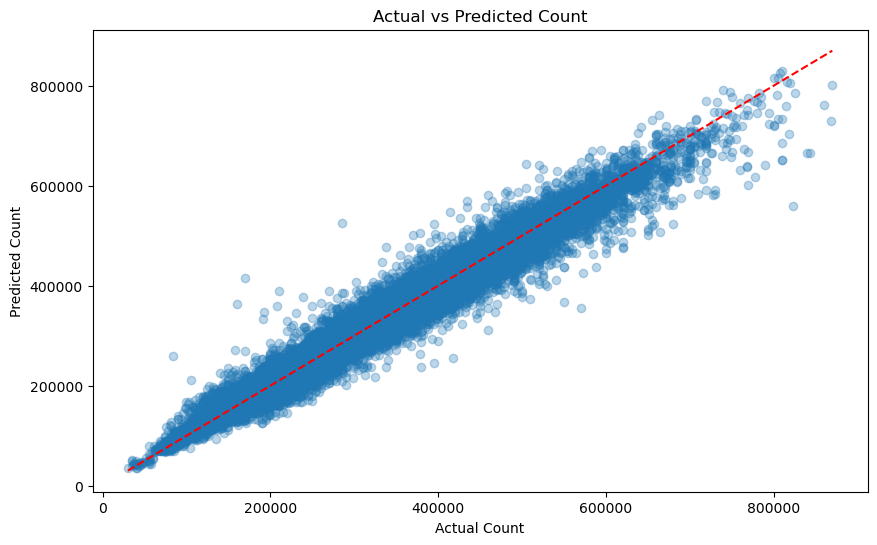

In [30]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Count')
plt.show()